# Figure 1: Plot canonical ground truth curves atop informative prior

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Samyukta Jayakumar, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v2

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Display four canonical phenotype Contrast Sensitivity Function (CSF) curves used in Experiment 1. Superimpose these curves on a Machine Learning Contrast Response Function (ML-CRF) defined by averaging Gaussian Processes (GPs) trained with simulated data that recapitulated each of the four canonical CSFs.

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.


In [1]:
# Import libraries

import sys
import torch as pt
import gpytorch as gp
from utility.utils import *

import numpy as np

import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Check versions of imported libraries

print("python version -->>", sys.version)
print("pytorch version -->>", pt.__version__)
print("gpytorch version -->>", gp.__version__)

python version -->> 3.10.9 (main, Mar  8 2023, 04:44:36) [Clang 14.0.6 ]
pytorch version -->> 1.13.1
gpytorch version -->> 1.8.1


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

In [3]:
# Run-time flags

verb_mode = True           # print verbose analyses?
scrn_mode = True           # plot on screen?
save_mode = True           # save plots in indicated directory?

plot_canon  = True         # plot canonical CSF spline-interpolated curves?
plot_prior  = True         # plot GP posterior mean as prior?
plot_thresh = False        # plot threshold curve of prior?

In [4]:
# Constant declarations

# Fix random seed
generative_random_seed = 1

# evaluation grid bounds in raw linear units
raw_freq_min = 1         # cycles per degree
raw_freq_max = 64        # cycles per degree
raw_contrast_min = 1e-3  # contrast
raw_contrast_max = 1     # contrast

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04  # lapse rate is 4%

# training parameters
num_initial_points = 8
num_initial_points_training_iters = 500
num_new_points = 120
num_new_points_training_iters = 150

# GP hyperparameters
scale_factor = 0.4
gaussian_lengthscale = None
min_lengthscale = 0.2

# detection threshold to visualize
det_thresh = 0.5 # 50%

In [5]:
# Standard plotting parameters

fig_width = 6     # inches
fig_height = 4.5  # inches

dpi_val = 600  # graphics resolution

plt.rcParams['font.family'] = 'Arial'

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 10
tick_font_weight = 'roman'
label_font_size = 12
label_font_weight = 'roman'
title_font_size = 14
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'

hist_color = 'lightgrey'  # fill color of histogram bars
colors = sns.color_palette('colorblind')  # colorblind friendly palette
col_1 = 0
col_2 = 1
col_3 = 2
col_4 = 4
mean_color = 'c'  # cyan

x_tick_labels = [1, 4, 16, 64]
x_tick_values = [0, 1, 2]
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_valuees = [0, 1, 2, 3]
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move colorbar xx units horizontally
cb_label_pad = -50  # move colorbar label xx units horizontally

num_spline_vals = 100  # number of interpolated points in spline curves

axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out'
}

color_map = 'gist_gray' # grayscale

p_title = 'Canonical Phenotypes & Informative Prior'
x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

save_dir  = './analysis/figure_01/'
file_stem = 'Figure01_CanonicalCSF&Prior'

data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp1.json'
data_file_path = f'{data_dir}{data_file_name}'

## Perform analysis

In [6]:
# Store canonical curves in standard form

# create list of phenotypes; curves digitized in log10 spatial frequency, log10 contrast

csf_curves_exp1 = load_json_from_file(data_file_path)

phenotypes = [
    ('Normal', csf_curves_exp1['normal']),
    ('Mild Amblyopia', csf_curves_exp1['mild_amblyopia']),
    ('Cataracts', csf_curves_exp1['cataracts']),
    ('Multiple Sclerosis', csf_curves_exp1['multiple_sclerosis'])
]

# convert digitized curves to proper units; interpolate with cubic splines
css = []
for title, curve in phenotypes:
    curvey = np.array(curve)
    # prepare freqs: change log10 to log2, and start from 0
    curvey[:, 0] = (np.log2(10) * curvey[:, 0]) - np.log2(0.125)
    left, right, _, _ = get_data_bounds(curvey)
    cs = create_cubic_spline(curvey)
    css.append((cs, left, right))
            
# convert raw bounds to log units
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# make evaluation grid
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, x_resolution, y_resolution)

In [7]:
# Compute the informative prior from simulated data

prior_model_names = ['textbook']

param_dicts = []

# get parameters needed for informative prior
for prior_model_name in prior_model_names[:]:
    param_dict = {
        'state_dict_path': f'data/priors/prior_mean_model_state_{prior_model_name}.pth',
        'Xt_path': f'data/priors/prior_mean_model_Xt_{prior_model_name}.pth',
        'scale_factor': scale_factor,
        'gaussian_lengthscale': gaussian_lengthscale,
        'min_lengthscale': min_lengthscale,
        'psi_gamma': psi_gamma,
        'psi_lambda': psi_lambda,
    }
    param_dicts.append(param_dict)

# function to scale data during GP training
def f(d):
    return scale_data_within_range(d, (0, 1), logFreq().forward(det_thresh), \
                                   logFreq().forward(raw_freq_max), y_min, y_max)

# create single point to initialize GP
x1 = logFreq().forward(np.array([raw_freq_max ]))
x2 = logContrast().forward(np.array(raw_contrast_min))
X = np.vstack((x1, x2)).T
y = np.array([0])
Xt = transform_dataset(X, phi=f)
yt = torch.from_numpy(y).float()

# setup model and likelihood
mean_module = get_mean_module('prior_gp_mean', param_dicts)
model = GPClassificationModel(Xt, mean_module=mean_module, min_lengthscale=min_lengthscale)
likelihood = CustomBernoulliLikelihood(psi_gamma, psi_lambda)

# get MLCRF
grid_transformed = transform_dataset(grid, phi=f)
Z = evaluate_posterior_mean(model, likelihood, grid_transformed)
zz = Z.reshape(xx.shape)

/Users/dbarbour/opt/anaconda3/envs/csf-env-manu1/lib/python3.10/site-packages/gpytorch/means/constant_mean.py:20: OldVersionWarning: You have loaded a GP model with a ConstantMean  from a previous version of GPyTorch. The mean module parameter `constant` has been renamed to `raw_constant`. Additionally, the shape of `raw_constant` is now *batch_shape, whereas the shape of `constant` was *batch_shape x 1. We have updated the name/shape of the parameter in your state dict, but we recommend that you re-save your model.
  warnings.warn(
/Users/dbarbour/opt/anaconda3/envs/csf-env-manu1/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_tri

## Plot figure

<Figure size 640x480 with 0 Axes>

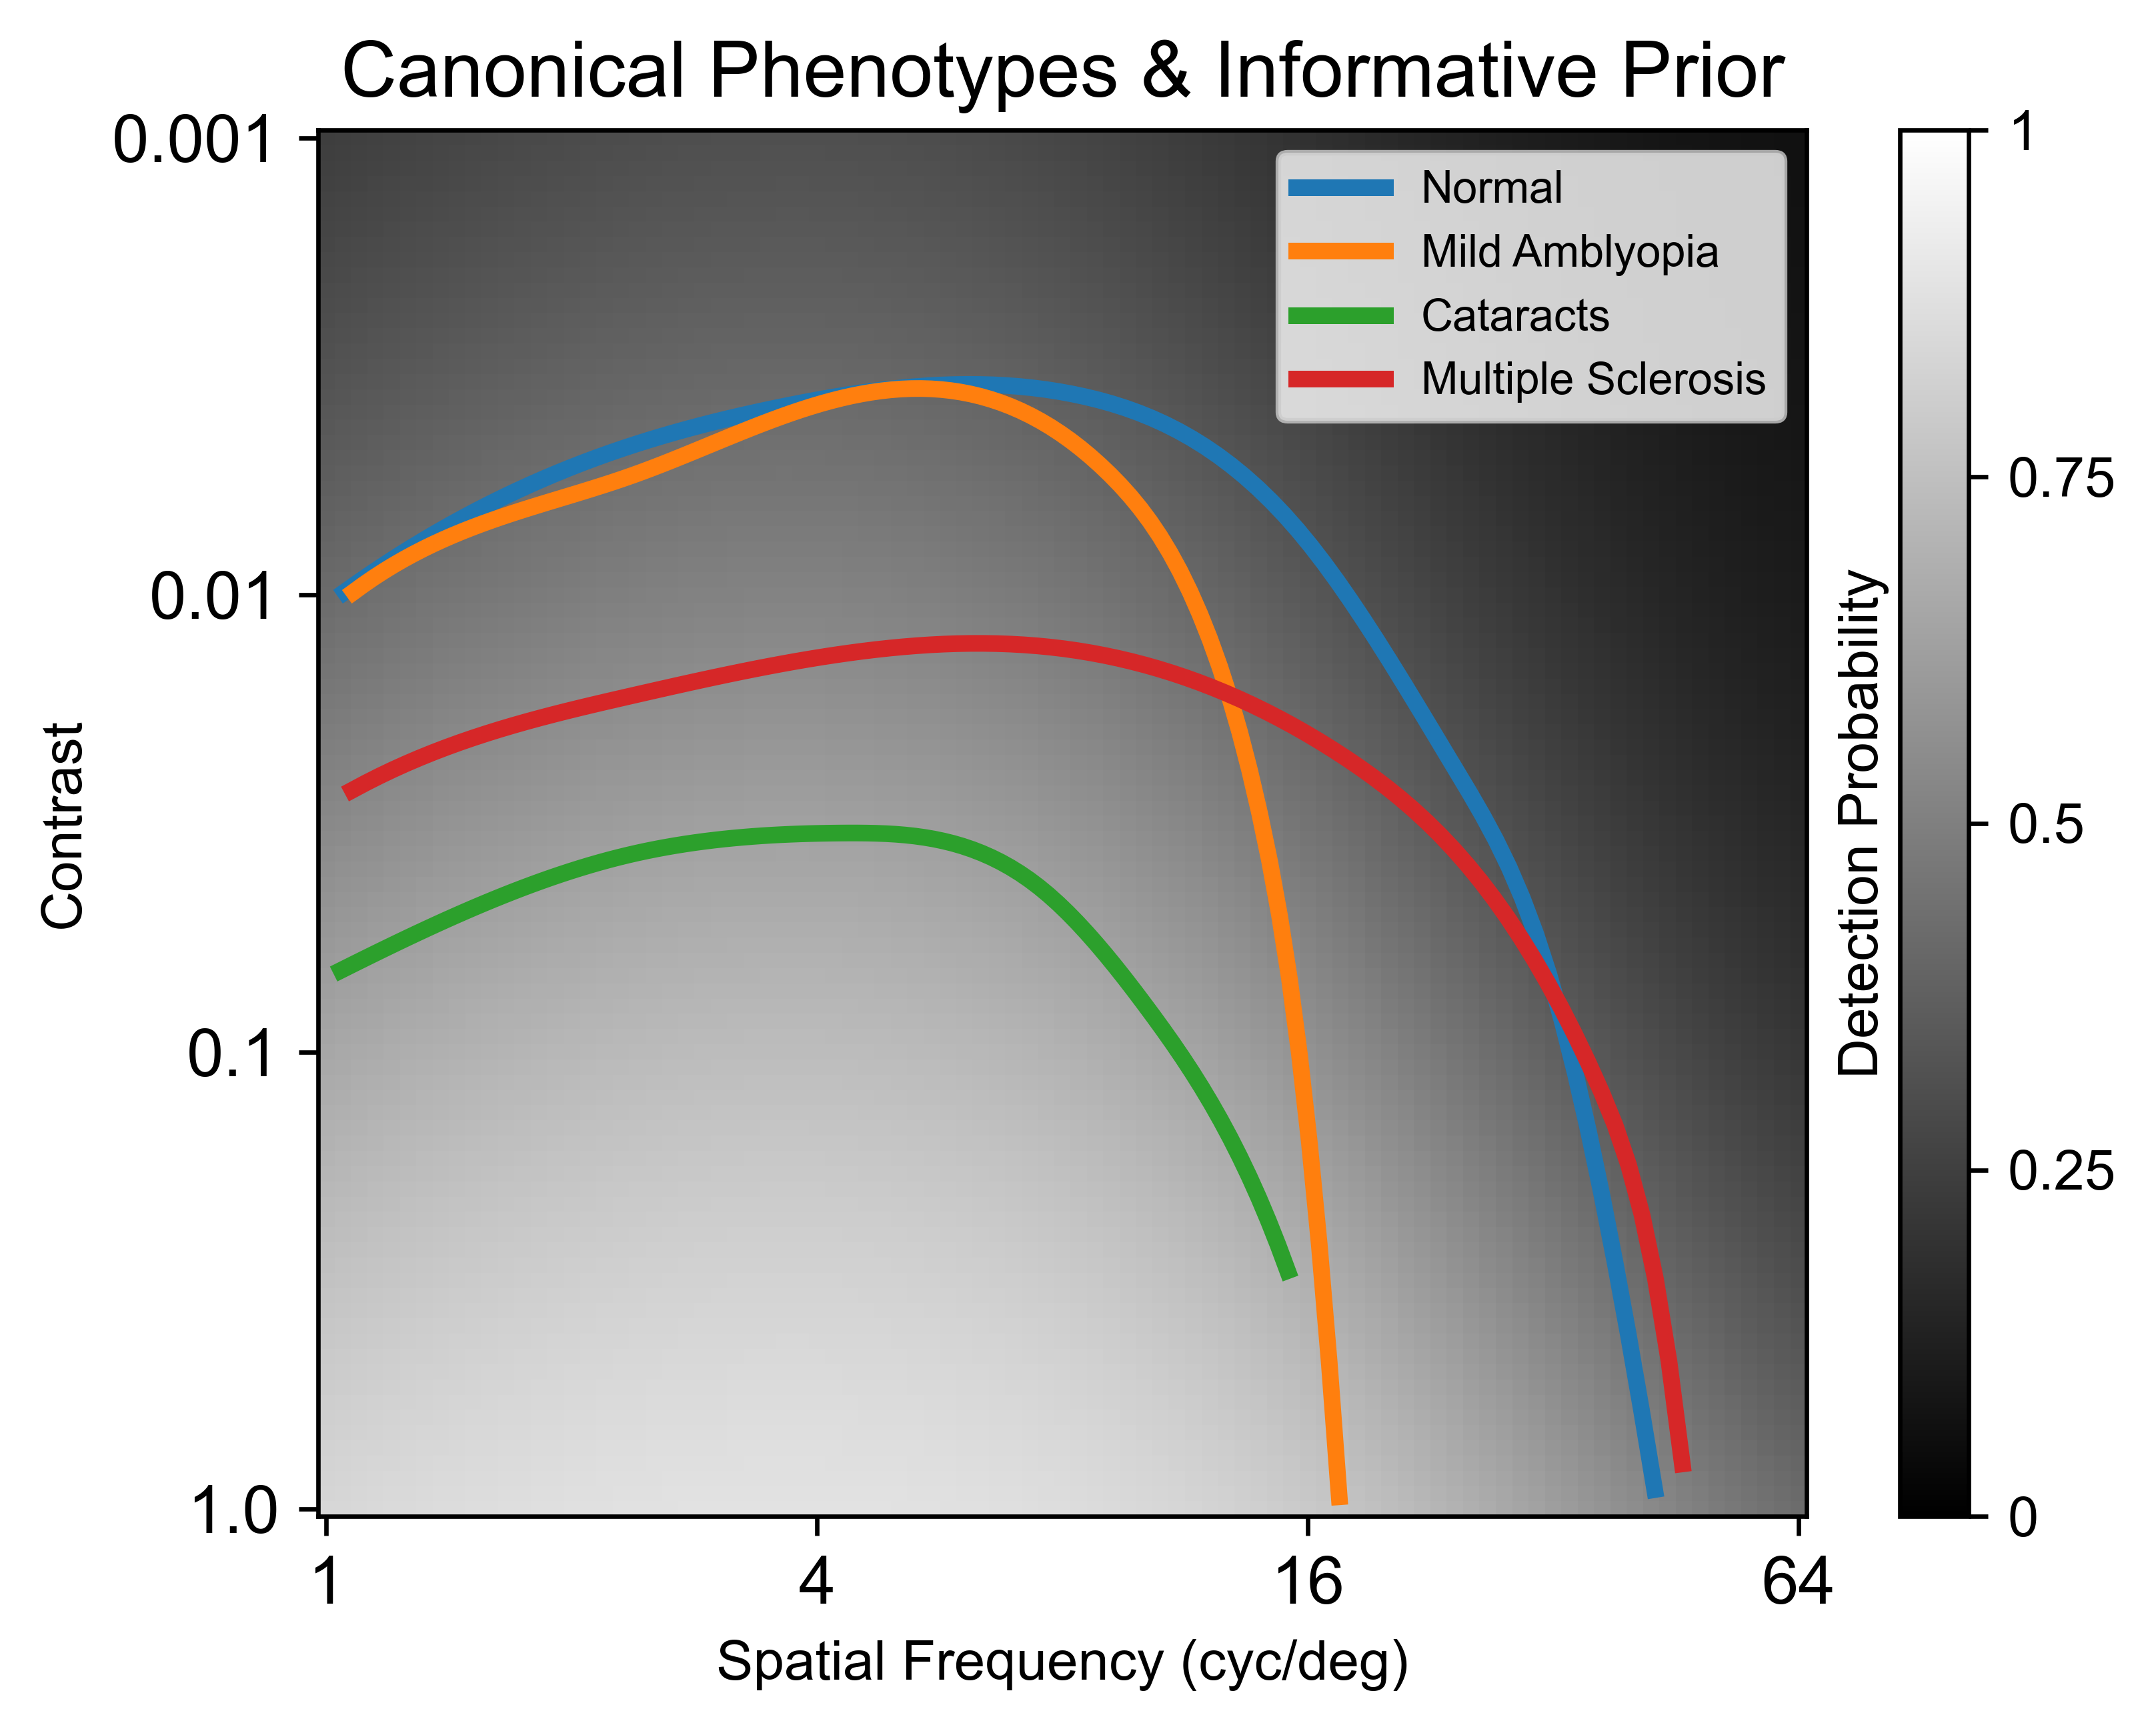

In [8]:
# Plot the canonical CSF curves on top of a GP posterior mean as CRF

%matplotlib inline
plt.tight_layout()

# set figure size
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi_val)

# plot the prior
if plot_prior:
    plt.pcolormesh(xx, yy, zz, cmap=color_map, vmin=min(cb_tick_values), vmax=max(cb_tick_values))
    cbar = plt.colorbar(pad=cb_pad)
    cbar.set_ticks(cb_tick_values)
    cbar.set_ticklabels(cb_tick_labels)
    cbar.set_label(cb_label, labelpad=cb_label_pad) # move colorbar label to the left xx units

# plot the canonical CSF thresholds
if plot_canon:
    for i, (cs, left, right) in enumerate(css):
        label = phenotypes[i][0]
        latent_x1 = np.linspace(left, right, num_spline_vals)
        latent_x2 = cs(latent_x1)
        plt.plot(latent_x1, latent_x2, label=label, linewidth=3)
    plt.legend(loc='upper right', fontsize=legend_font_size)

# plot the threshold curve
if plot_thresh:
    level = (1 - psi_lambda + psi_gamma) / 2
    plt.contour(xx, yy, zz, levels=[level], colors=[mean_color])

# specify the tick marks here
#   _labels are the numbers you want to display
#   _values are the underlying values corresponding to these labels;
#   in this case, the underlying values are log10 of the labels
#   _labels and _values must be the same length
x_ticks_labels = np.array(x_tick_labels)
x_ticks_values = logFreq().forward(x_ticks_labels)
y_ticks_labels = np.array(y_tick_labels)
y_ticks_values = logContrast().forward(y_ticks_labels)
plt.xticks(x_ticks_values, x_ticks_labels)
plt.yticks(y_ticks_values, y_ticks_labels)

# fit to the grid
x_padding = (x_max - x_min) / (2 * (xs - 1))
y_padding = (y_max - y_min) / (2 * (ys - 1))
plt.xlim(x_min - x_padding, x_max + x_padding)
plt.ylim(y_min - y_padding, y_max + y_padding)

# title and axis labels
plt.title(p_title, fontsize=title_font_size)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.tick_params(**axis_tick_params, labelsize=label_font_size)

if save_mode:
    ensure_directory_exists(save_dir)
    plt.savefig(f'{save_dir}{file_stem}.png', bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f'{save_dir}{file_stem}.pdf', bbox_inches='tight', dpi=dpi_val)

if scrn_mode:
    plt.show()
else:
    plt.clf()